In [1]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.simulation import *
# from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
 
cupyon=True

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")

# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920


cupy not installed. Using numpy.
cupy not installed. Using numpy.
cupy not installed. Using numpy.


In [6]:
######### Optimized tweezer generator

### Settings
gpuoptimization = True
#Phase Offsets available: Off_None, Off_Rand, Off_Calc 
optimizedinitialguess = True # If this is true, then phase offset is on 
phaseoffset = Off_Rand
phaseoffsetoptimization = True
# #Phase optimizers available: Phase_MinJumps, Phase_MinAmp
phaseoffsetfunction = Phase_MinJumps
harmonicremoval = True
# #Cost Functions available: Pen_DeltaSqrt, Pen_Sqrt, Pen_Exp
gwscostfunction = Pen_DeltaSqrt
# #Error Metrics available: Err_MaxMinDiff, Err_Uniformity, Err_PowerEff
errormetric = Err_MaxMinDiff


focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)
pixelpitch = (8 * 200/250 * 10**(-6))# microns
slmaperture = pixelpitch * 1200
# Simulation Constants
numpix_frame = 1300
numpix_real = 2048
aperturesize_real = numpix_real * pixelpitch
aperturesize_fourier = wavelength * focallength / (pixelpitch)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelpitch*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

tweezerspacing = 6
numxtweezers = 10
numytweezers = 10

distancefromcenter = 72
centerwidth = 250
centerheight = 250
print("Tweezer spacing in microns: ", pixelsize_fourier*10**6 * tweezerspacing)
print("Offset of tweezers from center in microns: ", pixelsize_fourier*10**6 * distancefromcenter)
airydiskradius = 1.22 * wavelength * focallength / (pixelpitch*1200)
print(f"Airy disk radius is: {airydiskradius * 10**6} microns")

Aod pixel pitch in microns:  6.3999999999999995
Fourier space spacing in microns:  0.4373931884765625
Fourier space aperture in microns:  895.78125
Tweezer spacing in microns:  2.624359130859375
Offset of tweezers from center in microns:  31.4923095703125
Airy disk radius is: 0.9107109375000002 microns


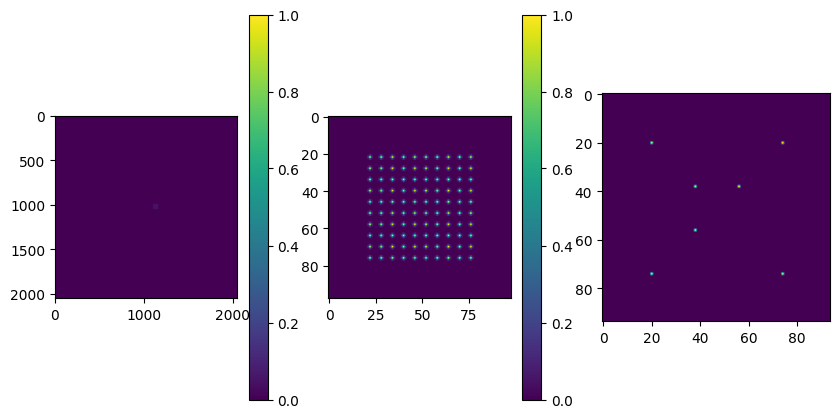

In [7]:

imgname = f"{numxtweezers}by{numytweezers}_{tweezerspacing}spacing_frame{numpix_frame}_real_{numpix_real}" # DEFINE NAME FIRST
tweezerarray = createtweezers_grid(cp.zeros((numpix_real,numpix_real)), tweezerspacing, numxtweezers, numytweezers, distancefromcenter )
anchorimg = createanchors(tweezerarray, tweezerspacing, magnification = 1.5)

sigma = airydiskradius / pixelsize_fourier / 4

tweezerarray = tweezerarray/cp.max(tweezerarray)
weightedtweezers, diffraction = applydiffractionlimited(tweezerarray, pixelsize_fourier , pixelpitch, wavelength, focallength)

gaussiantweezerarray = tocupy(apply_local_gaussian_filter(tonumpy(tweezerarray), sigma, tweezerspacing // 3))
gaussianweightedtweezers, diffraction = applydiffractionlimited(gaussiantweezerarray, pixelsize_fourier , pixelpitch, wavelength, focallength)


tweezerarray = tweezerarray / cp.max(tweezerarray)
weightedtweezers = weightedtweezers / cp.max(weightedtweezers)
gaussiantweezerarray = gaussiantweezerarray / cp.max(gaussiantweezerarray)
gaussianweightedtweezers = gaussianweightedtweezers / cp.max(gaussianweightedtweezers)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
im1 = axs[0].imshow(gaussianweightedtweezers, cmap='viridis')
im2 = axs[1].imshow(zoomin(gaussianweightedtweezers))
im3 = axs[2].imshow(zoomin(anchorimg))
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])

plt.show()


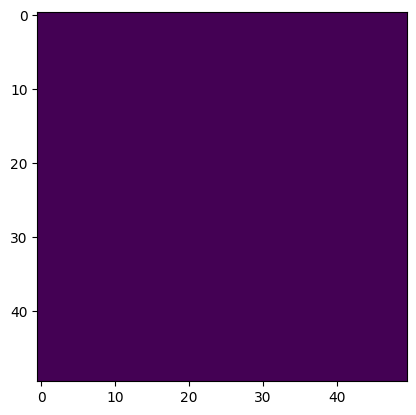

In [8]:
plt.imshow(gaussiantweezerarray[1150:1200,1200:1250])

In [9]:

randomguess = cp.random.rand(1300, 1300)
# Derive necessary phase for tweezers - fixed phase method
optimizedout_tweezer  = derivephase_fixed_zeropadding(Pen_LukinGaussian, Pen_LukinGaussian, gaussiantweezerarray, randomguess, 60, 15, uniformtarget=gaussiantweezerarray, magnification =1)

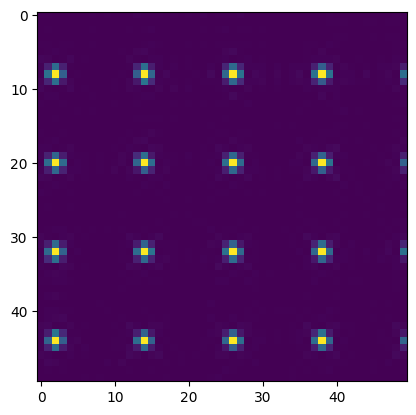

In [13]:
plt.imshow(optimizedout_tweezer.get_stdint()[1000:1050, 1150:1200])

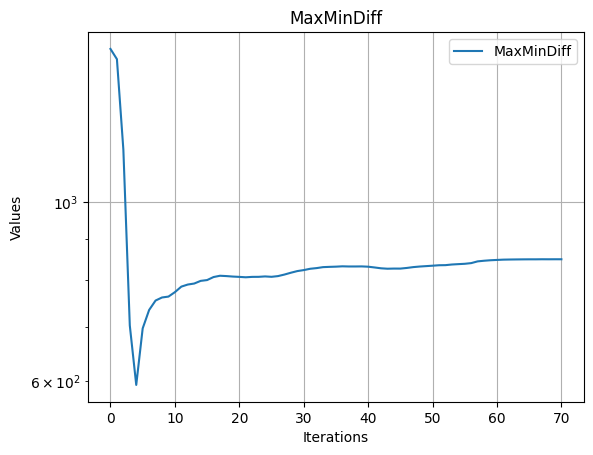

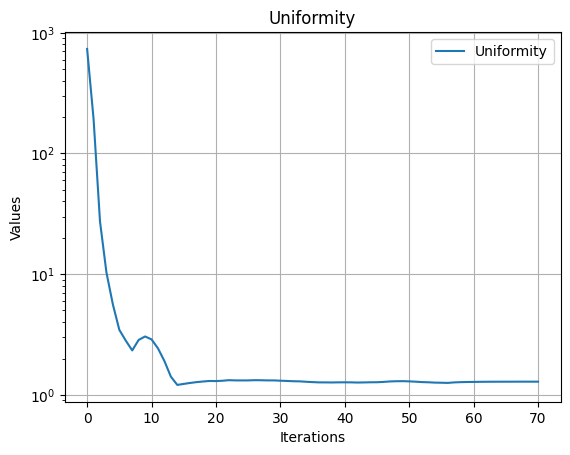

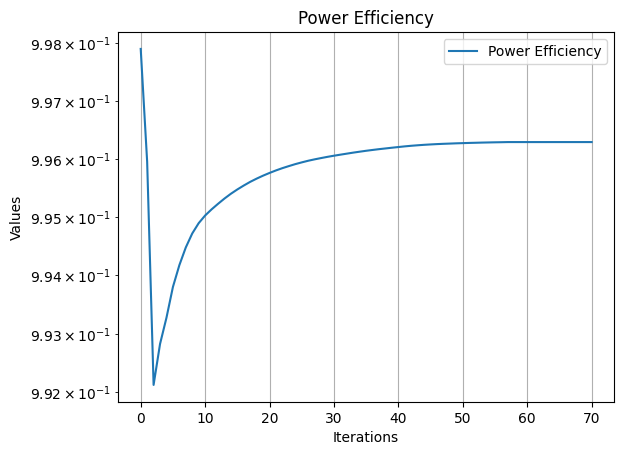

In [15]:
errors_thing = optimizedout_tweezer.get_all_errors()
labels_thing = optimizedout_tweezer.get_all_labels()

for i, label in enumerate(labels_thing): 
    plt.figure()
    plt.plot(errors_thing[i], label=label)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

In [10]:
optimizedout_anchors = derivephase_fixed_zeropadding(Pen_Lukin, Pen_Lukin, anchorimg, randomguess, 60, 10, uniformtarget = anchorimg)

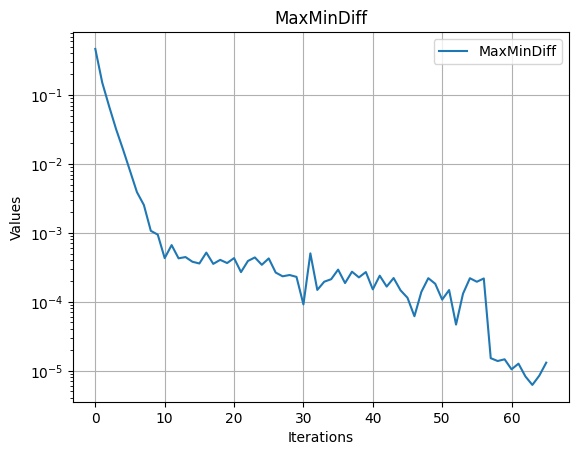

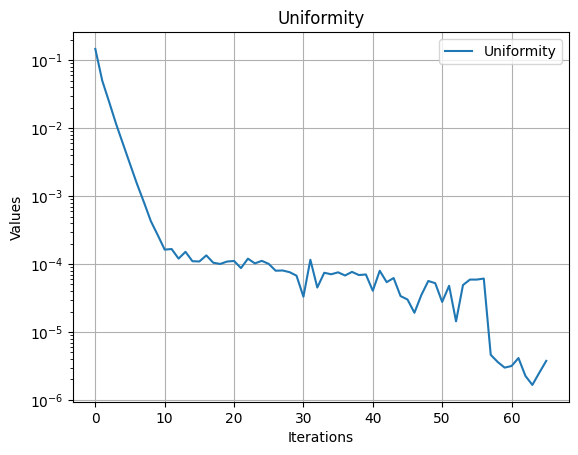

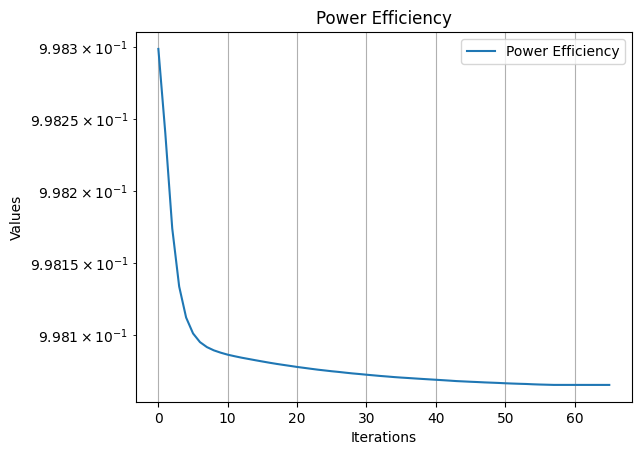

In [8]:
errors_thing = optimizedout_anchors.get_all_errors()
labels_thing = optimizedout_anchors.get_all_labels()

for i, label in enumerate(labels_thing): 
    plt.figure()
    plt.plot(errors_thing[i], label=label)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

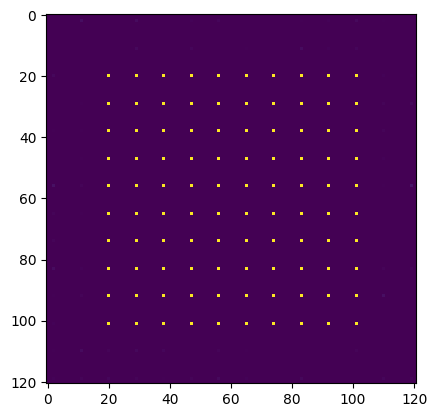

In [11]:
plt.imshow(zoomin(removeleftside((optimizedout_tweezer.get_stdint())), 10000))

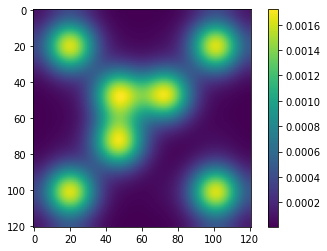

In [10]:
plt.imshow(gaussian_filter(zoomin(removeleftside(remove0thorder(optimizedout_anchors.get_stdint(),100),100), 1000000),10))
plt.colorbar()

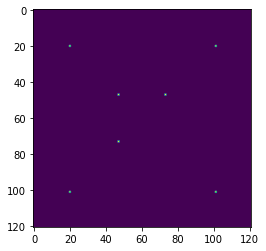

In [10]:
plt.imshow(zoomin(optimizedout_anchors.get_targetim()).get())

In [ ]:
# optimizedout_randguess  = derivephase(Pen_DeltaSqrt, tweezerarray, cp.random.rand(numpixels, numpixels), 100,1)
# kvector_initoffsets_none = Off_None(kvector_tweezers.get_magnitude(0), kvector_tweezers.get_angle(0), tweezerarray)
# initialphaseguess_nooffsets = create_phasemap(kvector_tweezers, kvector_initoffsets_none, wavetype=makesawtooth, opton=True, opttype=Phase_MinAmp, optiter=10)
# optimizedout_nooffsets  = derivephase(Pen_DeltaSqrt, tweezerarray, initialphaseguess_nooffsets, 1000,1)

In [11]:
# Convert to image files, and store!

# save_dir = r'Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage'  # For PC
# save_dir = r'C:\cleen\nsong\2-Research\UAC Research\Github\Ultracold-Research\GWS_Summer2024\storage' # For laptop

# Local Laptop storage
save_dir = r'C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage'

def save_to_file(GWSclass, filepath, filename):
    os.makedirs(filepath, exist_ok=True)  # Create the directory if it doesn't exist
    phaseimg_path = os.path.join(filepath, f"{filename}_phase.bmp")
    
    # Check if GWSclass.get_slmphase() is numpy or cupy array
    if isinstance(GWSclass.get_slmphase(), np.ndarray):
        slm_phase = GWSclass.get_slmphase()[50:1250, :]
    else:
        slm_phase = GWSclass.get_slmphase().get()[50:1250, :]  # Assuming cupy array
    
    saver = np.zeros((1200, 1920))
    saver[0:1200, int(1920/2-sizepix/2):int(1920/2+sizepix/2)] = discretize_phase(slm_phase)
    phaseimg = Image.fromarray(saver).convert('RGB')
    phaseimg.save(phaseimg_path)

    filename = filename + ".pkl"
    with open(os.path.join(filepath, filename), 'wb') as file:
        pickle.dump(GWSclass, file)
    print(f"Object saved to {os.path.join(filepath, filename)}")

save_to_file(optimizedout_tweezer, save_dir, f'tweezers{imgname}')
optimizedout_tweezer = load_from_file(save_dir, f'tweezers{imgname}')
save_to_file(optimizedout_anchors, save_dir, f'anchors{imgname}')
optimizedout_anchors = load_from_file(save_dir, f'anchors{imgname}')

Object saved to C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\tweezers10by10_6spacing_frame1300_real_2048.pkl
Object loaded from C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\tweezers10by10_6spacing_frame1300_real_2048.pkl
Object saved to C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\anchors10by10_6spacing_frame1300_real_2048.pkl
Object loaded from C:\cleen\nsong\2-Research\UAC Research\Github\ColdStorage\anchors10by10_6spacing_frame1300_real_2048.pkl


In [15]:
cp.min(discretize_phase(optimizedout_tweezer.get_slmphase()))

0.0

In [16]:
cp.max(discretize_phase(optimizedout_tweezer.get_slmphase()))

255.0

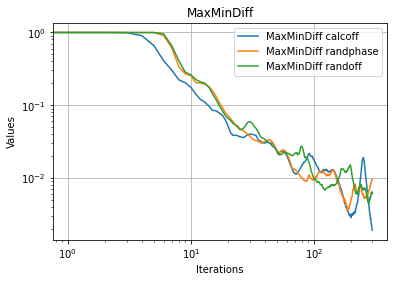

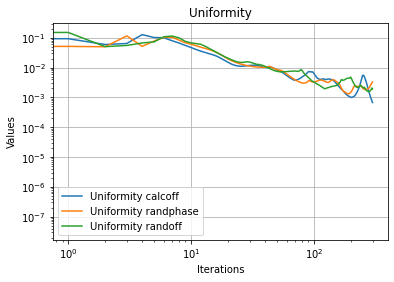

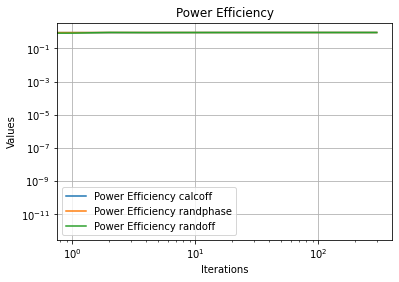

In [ ]:
errors = optimizedout.get_all_errors()
labels = optimizedout.get_all_labels()
errors_rand = optimizedout_randguess.get_all_errors()
labels_rand = optimizedout_randguess.get_all_labels()
errors_nooff = optimizedout_nooffsets.get_all_errors()
labels_nooff = optimizedout_nooffsets.get_all_labels()
for i, label in enumerate(labels):
    plt.figure()
    plt.loglog(errors[i].get(), label=str(cp.asnumpy(label))+" calcoff")
    plt.loglog(errors_rand[i].get(), label=str(cp.asnumpy(label))+" randphase")
    plt.loglog(errors_nooff[i].get(), label=str(cp.asnumpy(label))+" randoff")
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()
